#BERT Tutorials


#Section 1 - Fine-tuning a Text Classifier (detailed approach)
In this tutorial, we are going to apply the fine-tuning approach to use BERT to train a text classifier.



##1.1. Set Up
First, let's make sure GPU is available.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [2]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 31.7 MB/s eta 0:00:00


##1.2. Download and Prepare Data
First, get the data ready. We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.

Let's download the dataset usinng wget.

In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=67678c3f3bd7099d780d7cbb38c1116a707945802bdaac9f7fff6bd75778a41d
  Stored in directory: /Users/roychiu/Library/Caches/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [4]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [5]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


We'll use in_domain_train.tsv in the "raw" folder.
0=unacceptable, 1=acceptable

In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display the first 10 rows from the data.
df.head(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
5,gj04,1,NaN,I'll fix you a drink.
6,gj04,1,NaN,Fred watered the plants flat.
7,gj04,1,NaN,Bill coughed his way out of the restaurant.
8,gj04,1,NaN,We're dancing the night away.
9,gj04,1,NaN,Herman hammered the metal flat.


In [7]:
# Display 10 random rows from the data.
df.sample(10)

,sentence_source,label,label_notes,sentence
7429,sks13,0,*,"Mary won't have been eating cake, but John."
4541,ks08,0,*,"Mary sang a song, but Lee could never."
1219,r-67,1,NaN,The sheriff denied that gangsters had bribed him.
7820,ad03,1,NaN,Aphrodite misses Gilgamesh.
2170,l-93,1,NaN,The meat cuts easily.
1544,r-67,0,*,John is prouder of having gone than John expec...
7593,sks13,1,NaN,Mary considers John proud of himself.
4057,ks08,1,NaN,John mentioned to me that the question is an i...
7764,ad03,1,NaN,Jason would prefer Medea to have cursed Agamem...
3480,ks08,0,*,few evidence was provided.


In [8]:
print("No. of acceptable sentences: ", len(df.loc[df.label == 1]))
print("No. of unacceptable sentences: ", len(df.loc[df.label == 0]))
print("ratio of ones: ", len(df.loc[df.label == 1])/len(df))

#let's sample a few more unacceptable sentences
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

No. of acceptable sentences:  6023
No. of unacceptable sentences:  2528
ratio of ones:  0.704362062916618


,sentence,label
7490,I read these big three books.,0
2710,Packages drive easily.,0
8300,Bill reading of Shakespeare satisfied me,0
2334,The jeweller decorated the name on the ring.,0
4348,It said that Kim was happy.,0


In [9]:
# Get the lists of sentences and their labels.
sentences = list(df.sentence)
labels = torch.tensor(df.label)

##1.3. Encoding the data for BERT
Instead of using the manual coding we did in Tutorial1, easier functions exist from Bert Tokenizer to encode the data in batches.

In [10]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

2023-08-26 16:11:28.576085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BERT tokenizer...


Recall that either `tokenizer.encode_plus()` or `tokenizer()` can prepare the input text to the format we want.

In [11]:
print(tokenizer.encode_plus("This is my dog.", max_length = 15, padding = 'max_length'))

{'input_ids': [101, 2023, 2003, 2026, 3899, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


In [12]:
print(tokenizer(["This is my dog.", "It's very cute."], max_length = 15, padding = 'max_length', return_tensors = "pt"))

{'input_ids': tensor([[  101,  2023,  2003,  2026,  3899,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2009,  1005,  1055,  2200, 10140,  1012,   102,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


To set the max_length with a reasonable number, let's find out how long our longest sentence is in the dataset.

In [13]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [14]:
encoded_sents = tokenizer(sentences,
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)

##1.4. Split Dataset for Training and Validation
Let's get 90% for training and 10% for validation

In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
#dataset = TensorDataset(input_ids, attention_masks, labels)
dataset = TensorDataset(encoded_sents['input_ids'], encoded_sents['attention_mask'], labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

##1.5. Create the classification model
We use the task-specific BERT class for sequence classification, which is BERT + 1 linear layer for classification.

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

AssertionError: Torch not compiled with CUDA enabled

And define the optimizer and learning rate scheduler.

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

964


In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


##1.6. Train the model!

In [21]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()



In [22]:
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Accumulate the validation loss.
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:51.
  Batch   200  of    241.    Elapsed: 0:01:04.
  Batch   240  of    241.    Elapsed: 0:01:16.

  Average training loss: 0.51
  Training epoch took: 0:01:16

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.43
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:26.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:52.
  Batch   200  of    241.    Elapsed: 0:01:05.
  Batch   240  of    241.    Elapsed: 0:01:18.

  Average training loss: 0.34
  Training epoch took: 0:01:18

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

In [23]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.5119272594753638,
  'Valid. Loss': 0.4297938214408027,
  'Valid. Accur.': 0.8171296296296297,
  'Training Time': '0:01:16',
  'Validation Time': '0:00:03'},
 {'epoch': 2,
  'Training Loss': 0.3373587295042034,
  'Valid. Loss': 0.4007449023149632,
  'Valid. Accur.': 0.8445216049382716,
  'Training Time': '0:01:18',
  'Validation Time': '0:00:03'},
 {'epoch': 3,
  'Training Loss': 0.21470680520618604,
  'Valid. Loss': 0.4522254934741391,
  'Valid. Accur.': 0.8472222222222222,
  'Training Time': '0:01:18',
  'Validation Time': '0:00:03'},
 {'epoch': 4,
  'Training Loss': 0.15177068287792667,
  'Valid. Loss': 0.5252621481540026,
  'Valid. Accur.': 0.8449074074074074,
  'Training Time': '0:01:18',
  'Validation Time': '0:00:03'}]

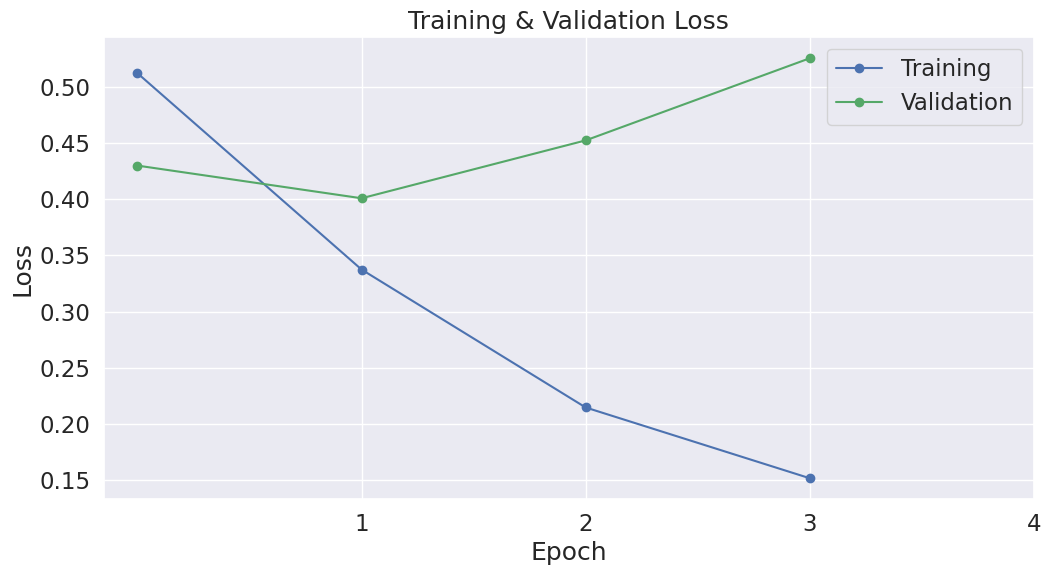

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##1.7. Test our model on test set
The test set needs to be prepared in the same way as the training set.

In [25]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_test = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t',
                 header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
sentences_test = df_test.sentence.values
labels_test = df_test.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [26]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [27]:
predictions[0]

array([[-2.0135696 ,  2.6432984 ],
       [-1.9191337 ,  2.5790634 ],
       [-2.0870419 ,  2.740778  ],
       [-2.0794697 ,  2.685303  ],
       [-1.8336368 ,  2.254622  ],
       [-2.1138513 ,  2.7944891 ],
       [-0.9454928 ,  0.97946495],
       [-1.7969599 ,  2.4113119 ],
       [-1.9746512 ,  2.7782466 ],
       [-1.8540295 ,  2.5879195 ],
       [-1.8218144 ,  2.427465  ],
       [ 1.1678476 , -1.5866506 ],
       [-1.9167497 ,  2.3260574 ],
       [-1.5747105 ,  1.9352064 ],
       [-1.7538455 ,  2.3719928 ],
       [-1.5065728 ,  1.9085351 ],
       [-1.4283887 ,  1.8428771 ],
       [ 2.0503647 , -2.224374  ],
       [-1.9553586 ,  2.6079288 ],
       [-1.7608562 ,  2.3265939 ],
       [-1.9553586 ,  2.6079288 ],
       [-1.8828868 ,  2.3487394 ],
       [-1.7004445 ,  2.1103177 ],
       [-1.9363858 ,  2.51784   ],
       [-1.2509192 ,  1.4106035 ],
       [-1.912647  ,  2.4878514 ],
       [-1.9644494 ,  2.5207    ],
       [-1.9731832 ,  2.497434  ],
       [-2.0653677 ,

In [28]:
total_test_accuracy = 0
for p, t in zip(predictions, true_labels):
  print("Accuracy for batch: ", flat_accuracy(p, t))
  total_test_accuracy += flat_accuracy(p, t)

print("Overall accuracy for test set:", total_test_accuracy/len(predictions))

Accuracy for batch:  0.59375
Accuracy for batch:  0.59375
Accuracy for batch:  0.71875
Accuracy for batch:  0.75
Accuracy for batch:  0.75
Accuracy for batch:  0.875
Accuracy for batch:  0.78125
Accuracy for batch:  0.90625
Accuracy for batch:  0.96875
Accuracy for batch:  0.8125
Accuracy for batch:  0.90625
Accuracy for batch:  0.875
Accuracy for batch:  0.9375
Accuracy for batch:  0.90625
Accuracy for batch:  0.8125
Accuracy for batch:  0.78125
Accuracy for batch:  0.75
Overall accuracy for test set: 0.8069852941176471


In [29]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.label.sum(), len(df_test.label), (df_test.label.sum() / len(df_test.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [30]:
for t in true_labels:
  print('Positive samples in batch: %d of %d (%.2f%%)' % (t.sum(), len(t), (t.sum() / len(t) * 100.0)))

Positive samples in batch: 19 of 32 (59.38%)
Positive samples in batch: 22 of 32 (68.75%)
Positive samples in batch: 19 of 32 (59.38%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 21 of 32 (65.62%)
Positive samples in batch: 19 of 32 (59.38%)
Positive samples in batch: 20 of 32 (62.50%)
Positive samples in batch: 28 of 32 (87.50%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 17 of 32 (53.12%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 19 of 32 (59.38%)
Positive samples in batch: 26 of 32 (81.25%)
Positive samples in batch: 26 of 32 (81.25%)
Positive samples in batch: 21 of 32 (65.62%)
Positive samples in batch: 3 of 4 (75.00%)


The dataset is imbalanced. A better way to measure performance is "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC), which ranges from -1 to 1.

In [31]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch, convert the predicted logits to 0/1 labels...
for i in range(len(predictions)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())


# For each input batch...
for i in range(len(true_labels)):

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels[i])
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-32-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


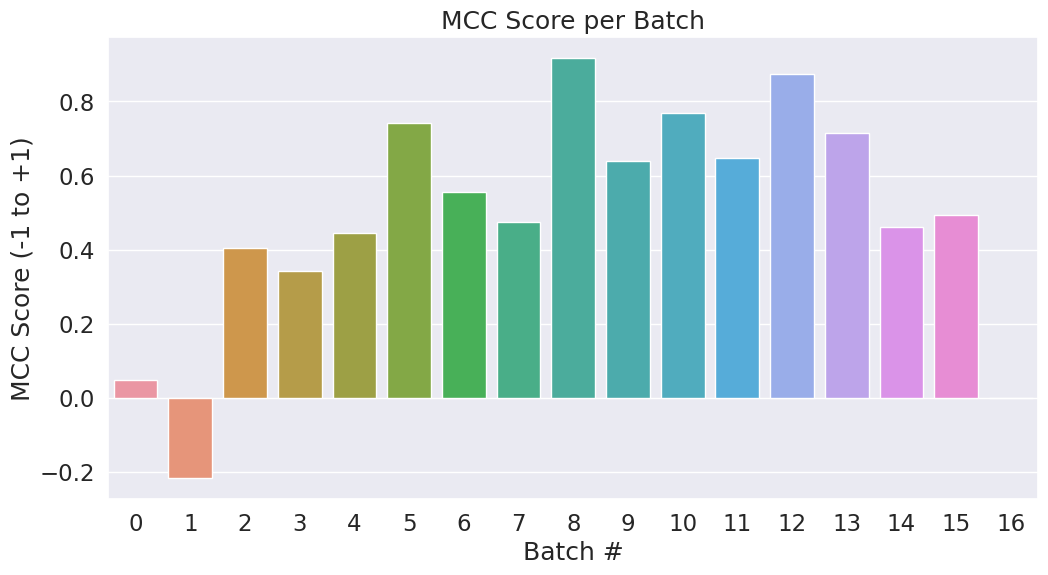

In [32]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [33]:
pred_labels[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
true_labels[0]

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [35]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_pred_labels = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_pred_labels)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.535


In [36]:
#Saving your model.
output_file = "./model_bert_ft_cola.pth"

def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)


In [ ]:
#In the future, if you want to continue to work on this model, you can load it back in.
checkpoint = torch.load(output_file, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Section 2 - Alternative way of finetuning for Text Classification using the Trainer API
The Transformers library provides a lot of useful resources, like the common datasets used for various nlp tasks, and also the Trainer class, which makes the codes for fine-tuning much shorter.

In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


##2.1. Prepare the dataset
The same "cola" dataset is available in the library as part of the GLUE benchmark datasets. It's well organized into train, validation, and test sets.

In [8]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "cola")

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [40]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

In [9]:
# tokenize the sentences in three datasets
# map() allows easy application of the same pre-processing to different sets of data.

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

encoded_datasets = raw_datasets.map(tokenize_function, batched=True)
encoded_datasets

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1063
    })
})

##2.2. Prepare the training arguments required by the Trainer


In [10]:
# A data collator will put together samples in a batch, and of same length with
# dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

A TrainingArguments class contains all the hyperparameters the
Trainer will use for training and evaluation. We use all defaults, and set
the directory for saving trained model, and model evaluation to be done after
each epoch.

In [11]:
from transformers import TrainingArguments, Trainer
from accelerate import Accelerator
from transformers import AutoModelForSequenceClassification

accelerator = Accelerator()
device = accelerator.device


In [28]:
training_args = TrainingArguments("finetune-cola",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=2) #default is 3

We also need to define a metrics function to be passed to the trainer.

In [25]:
!pip install evaluate
import evaluate
import numpy as np

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "cola")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
# prepare the model to be fine-tuned
checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

##2.3. Create the Trainer and train

In [26]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=encoded_datasets["train"],
    eval_dataset=encoded_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [27]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Matthews Correlation
1,0.221100,1.022643,0.533410
2,0.151000,0.965147,0.563576
3,0.085000,1.148391,0.531637


TrainOutput(global_step=3207, training_loss=0.14616864427138906, metrics={'train_runtime': 323.3671, 'train_samples_per_second': 79.331, 'train_steps_per_second': 9.918, 'total_flos': 240008157477540.0, 'train_loss': 0.14616864427138906, 'epoch': 3.0})

#Section 3 - Finetuning BERT for Token Classification
Let's continue to use Trainer for the finetuning task of token classification.

In [4]:
#recap the necessary libraries here
!pip install datasets
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import numpy as np
!pip install evaluate
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.7 MB/s eta 0:00:00


##3.1. Prepare the dataset
The data set is for a task of recognizing emerging and rare entities. Each record has a sequence of tokens (the sentence is pre-tokenized) and a sequence of entity tags.

In [9]:
# WNUT 17: Emerging and Rare entity recognition dataset
wnut = load_dataset("wnut_17")
wnut

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3394
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1287
    })
})

In [7]:
example = wnut["train"][0]
for k in example.keys():
  print(example[k])

0
['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# What are these tags(labels) refering to?
label_list = wnut["train"].features[f"ner_tags"].feature.names
label_list

['O',
 'B-corporation',
 'I-corporation',
 'B-creative-work',
 'I-creative-work',
 'B-group',
 'I-group',
 'B-location',
 'I-location',
 'B-person',
 'I-person',
 'B-product',
 'I-product']

The sentences have to be tokenized using the model specific tokenizer. The resulting tokens do not necessarily match the words in the sentences coming from the data set. Therefore, an alignment step is needed to match the tokenizer's results to the words.

In [48]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [49]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokenized_input)
print(tokens)

{'input_ids': [101, 1030, 2703, 17122, 2009, 1005, 1055, 1996, 3193, 2013, 2073, 1045, 1005, 1049, 2542, 2005, 2048, 3134, 1012, 3400, 2110, 2311, 1027, 9686, 2497, 1012, 3492, 2919, 4040, 2182, 2197, 3944, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', '@', 'paul', '##walk', 'it', "'", 's', 'the', 'view', 'from', 'where', 'i', "'", 'm', 'living', 'for', 'two', 'weeks', '.', 'empire', 'state', 'building', '=', 'es', '##b', '.', 'pretty', 'bad', 'storm', 'here', 'last', 'evening', '.', '[SEP]']


In [50]:
#Aligning the tokens to labels
#Mapping all tokens to their corresponding word with the word_ids method.
#Assigning the label -100 to the special tokens [CLS] and [SEP] so the PyTorch loss function ignores them.
#Only labeling the first token of a given word. Assign -100 to other subtokens from the same word.

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [51]:
tokenized_wnut = wnut.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

In [52]:
tokenized_wnut

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3394
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1287
    })
})

In [53]:
tokenized_example = tokenized_wnut["train"][0]
for k in tokenized_example.keys():
  print(tokenized_example[k])

0
['@paulwalk', 'It', "'s", 'the', 'view', 'from', 'where', 'I', "'m", 'living', 'for', 'two', 'weeks', '.', 'Empire', 'State', 'Building', '=', 'ESB', '.', 'Pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 1030, 2703, 17122, 2009, 1005, 1055, 1996, 3193, 2013, 2073, 1045, 1005, 1049, 2542, 2005, 2048, 3134, 1012, 3400, 2110, 2311, 1027, 9686, 2497, 1012, 3492, 2919, 4040, 2182, 2197, 3944, 1012, 102]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-100, 0, -100, -100, 0, 0, -100, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 7, 8, 8, 0, 7, -100, 0, 0, 0, 0, 0, 0, 0, 0, -100]


##3.2. Prepare the arguments required by the Trainer


In [54]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [55]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=14)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [56]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

A different evaluation metric is needed for sequence labeling evaluation, where precision, recall, and F1 are reported for each type of tag as well as overall performance. During fine-tuning, we just want to see the overall performance.

In [57]:
!pip install seqeval
metric = evaluate.load("seqeval")

In [24]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

##3.3. Create the Trainer and train

In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_wnut["train"],
    eval_dataset=tokenized_wnut["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [59]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.299504,0.586420,0.264133,0.364217,0.939720
2,No log,0.295413,0.602518,0.310473,0.409786,0.943611
3,0.178400,0.295786,0.564492,0.344764,0.428078,0.944722


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=639, training_loss=0.1567117261214995, metrics={'train_runtime': 137.7433, 'train_samples_per_second': 73.92, 'train_steps_per_second': 4.639, 'total_flos': 276451337215056.0, 'train_loss': 0.1567117261214995, 'epoch': 3.0})

In [60]:
#if you want to explicitly run the evluate step of the model using the test set
trainer.evaluate()

{'eval_loss': 0.2957858443260193,
 'eval_precision': 0.5644916540212443,
 'eval_recall': 0.3447636700648749,
 'eval_f1': 0.42807825086306106,
 'eval_accuracy': 0.9447223291009362,
 'eval_runtime': 6.0323,
 'eval_samples_per_second': 213.351,
 'eval_steps_per_second': 13.428,
 'epoch': 3.0}

##3.4. Test the model with a separate data set
To get the metrics calculated for each category of labels

In [61]:
raw_predictions, labels, _ = trainer.predict(tokenized_wnut["validation"])
predictions = np.argmax(raw_predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'corporation': {'precision': 0.3333333333333333,
  'recall': 0.29411764705882354,
  'f1': 0.3125,
  'number': 34},
 'creative-work': {'precision': 0.21052631578947367,
  'recall': 0.0761904761904762,
  'f1': 0.11188811188811189,
  'number': 105},
 'group': {'precision': 0.2727272727272727,
  'recall': 0.23076923076923078,
  'f1': 0.24999999999999994,
  'number': 39},
 'location': {'precision': 0.5128205128205128,
  'recall': 0.5405405405405406,
  'f1': 0.5263157894736842,
  'number': 74},
 'person': {'precision': 0.7837209302325582,
  'recall': 0.7170212765957447,
  'f1': 0.7488888888888889,
  'number': 470},
 'product': {'precision': 0.42,
  'recall': 0.18421052631578946,
  'f1': 0.25609756097560976,
  'number': 114},
 'overall_precision': 0.644916540212443,
 'overall_recall': 0.5083732057416268,
 'overall_f1': 0.568561872909699,
 'overall_accuracy': 0.9539067963634051}

# References

BERT Fine-Tuning Tutorial with PyTorch, By Chris McCormick and Nick Ryan (The original post is [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/).)

Transformers documentation on token classification. (https://huggingface.co/docs/transformers/tasks/token_classification)